Here, we detect bad channels and then interpolate those channels deemed bad.

#### Loading the data...

In [57]:
%matplotlib inline
import cPickle as pkl
base = '../../nicolas/'
path = ''
file_name = 'sub-0001_ses-01.pkl'
full_path = base + path + file_name
with open(full_path, 'rb') as f:
    D = pkl.load(f)
with open(base + 'chan_locs.pkl') as f:
    chan_locs = pkl.load(f)

#### Visualizing the data...

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from panda.methods import viz as viz
from panda import config
p_global = config.params['p_global']
eog_chans = np.array(p_global['eog_chans']) - 1
eeg_chans = np.setdiff1d(np.arange(128), eog_chans)
p_global.update({'eog_chans': eog_chans,
                'eeg_chans': eeg_chans})
p_global['inter'].update({'chan_locs': chan_locs})
p_global['plotting']['notebook'] = True

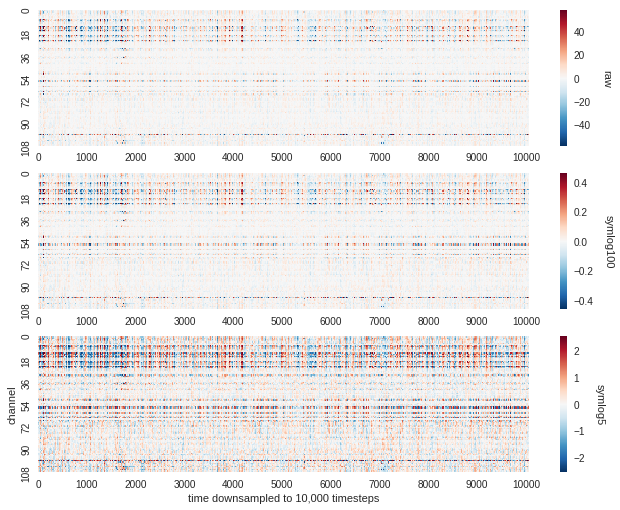

In [59]:
from panda.methods.misc import setup
from panda.methods.denoise import highpass
from panda.methods.denoise import bandstop
from panda.methods.denoise import wave_rejection
from panda.methods.denoise import eog_regress
from panda.methods.denoise import amp_shrinkage
(D, p_local) = setup(D, {}, p_global)
(D, p_local) = highpass(D, p_local, p_global)
#(D, p_local) = bandstop(D, p_local, p_global)
(D, p_local) = eog_regress(D, p_local, p_global)
(D, p_local) = wave_rejection(D, p_local, p_global)
(D, p_local) = amp_shrinkage(D, p_local, p_global)
viz.heatmap(D, p_local, p_global)

Test
[]
Here
Here
[102  74 102 103 108]


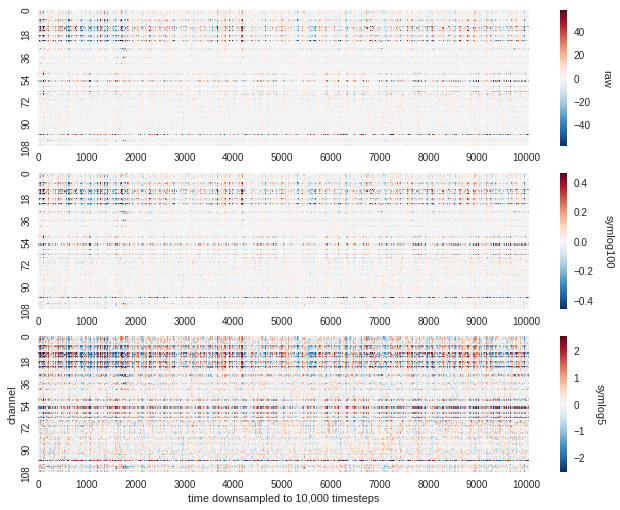

In [68]:
from panda.methods.bad_chans import bad_detec
(D_bd, p_local) = bad_detec(D, p_local, p_global)
print p_local['bad_chans']
viz.heatmap(D_bd, p_local, p_global)

## Setting

Suppose we have $D$ channels sampling activity over time. For various reasons (faulty connection, bad contact with scalp, etc) channels can receive highly noisy/incorrect data. To account for this, different metrics have been found that help identify these electrodes. We explore using 2 of those metrics here.

### Kurtosis

The first metric we explore is kurtosis. Kurtosis is the ratio of the $4^{th}$ moment of a distribution and its $2^{nd}$ moment squared; it represents how much of the data resides in the **tails** of the distribution; i.e. it sees how much of the data lies outside of the first standard deviation in the distribution, which is influenced by larger outliers. Thus, filtering based on kurtosis is essentially filtering based on the larger presence of outliers. In the context of our situation, it means catching electrodes with a significant more/less spread of values than the rest.

If our empirical data is a set of points $\{ X_i \}_{i=1}^n$, with mean $\bar{X}$ and standard deviation $\sigma$:

$$Kurtosis = \frac{\mathbb{E}[X^4]}{\mathbb{E}[X^2]^2} = \frac{\frac{1}{N}\sum_{i=1}^{N}(X_i - \bar{X})^4}{\sigma^4}$$

An additional common measure is **excess kurtosis** which is essentially kurtosis compared to the kurtosis of a standard deviation, which is 3.

Higher kurtosis indicates longer + fatter tails (ie more weight there) and sharper peak, lower indicates short, thin tails with broad center.

$Excess Kurtosis = Kurtosis - 3$

### KS-Statistic

The KS-Statistic is a non-parametric metric of simialrity between 2 distributions (ie compare a sample distribution with a "true" distribution and find the closeness).

Basically, for $n$ i.i.d. observations, $X_i$, if we divide our domain into $k$ bins, we can define the empirical distribution function $F_n(x)$:

$$F_n(x) = \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{x_k} (X_i)$$

Where $\mathbb{1}_{x_k} (X_i)$ is 1 if $X_i$ lies in the same bin as $x$ and 0 otherwise. 

The KS-Statistic for this distribution, with given true cumulative distribution funciton $F(x)$, is:

$$D_n = \sup_x | F_n(x) - F(x) | $$

Where $ \sup_x $ is the supremum of the distances.

In the context of our data, we find the distance between each electrode's distributions and a Gaussian distribution. Using these distances, we see if any electrodes are significantly further/closer to the Gaussian than the rest and call those bad.

## Pseudocode

### kurt_badelec:
Find the kurtosis of each of the electrodes and see which are outliers.

**Input**:

1. EEG data $\mathcal{D} \in C \times N \times T$
    1. $C = $ # of channels
    2. $N = $ # of timesteps per trial
    3. $T = $ # of trials
2. Threshold; the number of standard deviations away the kurtosis can be (default to 3): $\tau \in \mathbb{R}$

**Output**: Array of all bad electrode indices

KURT_BADELEC($\mathcal{D}$):

1. $\mathcal{D}$ = reshape$(\mathcal{D} \in C \times N \times T \rightarrow  \mathcal{D} \in C \times (N \times T))$
2. $\mathcal{K}$ = vector( $C$ )
3. **For** ($c \in 1, \ldots, C$):
    1. $\mathcal{K}[c]$ = get\_kurtosis($\mathcal{D}[c,:]$)
4. $\mu = \frac{1}{C} \sum \mathcal{K}$, $\sigma = \frac{1}{C} \sqrt{\sum_{c = 1}^C \mathcal{K}[c] - \mu}$
5. $\mathcal{R} = [\ ]$
6. **For** ($c \in 1, \ldots, C$):
    1. **If** ($\frac{\mu - \mathcal{K}[c]}{\sigma} > \tau$ ):  $\mathcal{R}.$append$[c]$
6. **return** $\mathcal{R}$


### ks_badelec:

Find the KS statistic of each of the electrodes relative to a Gaussian distribution and see which are significantly further/closer to the Gaussian than the rest.

**Input**:

1. EEG data $\mathcal{D} \in C \times N \times T$
    1. $C = $ # of channels
    2. $N = $ # of timesteps per trial
    3. $T = $ # of trials
2. Threshold; the number of standard deviations away the kurtosis can be (default to 3): $\tau \in \mathbb{R}$

**Output**: Array of all bad electrode indices

KS_BADELEC($\mathcal{D}$):

1. $\mathcal{D}$ = reshape$(\mathcal{D} \in C \times N \times T) \rightarrow  \mathcal{D} \in C \times (N \times T)$
2. $\mathcal{KS}$ = vector( $C$ )
3. **For** ($c \in C$):
    1. $\mu_c = \frac{1}{N \times T} \sum \mathcal{D}[c,:]$, $\sigma_c = \frac{1}{N \times T} \sqrt{\sum_{i=1} \mathcal{D}[c,i] - \mu_c}$
    2. **For** ($i \in 1, \ldots, N \times T$):
        1. $\mathcal{D}[c,i] = \frac{\mathcal{D}[c,i] - \mu_c}{\sigma_c}$
    3. $M$ = max($D[c,:]$), $m$ = min($D[c,:]$)
    4. $S = linspace(0, 1, d) \times (M - m) + m$
    5. $F = get\_cdf(\mathcal{N}(0, 1), S)$
    6. $F_c = get\_cdf(\mathcal{D}[c,:], S)$
    7. $\mathcal{KS}.append(\ \sup_x | F_n(x) - F(x) |\ )$
5. $\mathcal{R} = [\ ]$
4. $\mu = \frac{1}{C} \sum \mathcal{KS}$, $\sigma = \frac{1}{C} \sqrt{\sum_{c = 1}^C \mathcal{KS}[c] - \mu}$
6. **For** ($c \in C$):
    1. **If** ($\frac{\mu - \mathcal{KS}[c]}{\sigma} > \tau$ ):  $\mathcal{R}.$append$[c]$
6. **return** $\mathcal{R}$

## Simulations

With our real data, we can measure succes by looking at how the electrodes chosen qualitatively compare to nearby electrodes and how removing the electrodes influences discriminability. With simulated data we can look at how the electrodes chosen compare to the ones we know are bad.

### Generating Sample Data

We generate two types of sample data: data for which we expect the algorithm to perform well, and data for which we expect the algorithm to perform poorly.

1. (Good Case) The bad electrodes have considerable noise and the good electrodes are identical:
    - 50 sine waves, all 50 the same wave, 1 with lots of white noise
    - Should result in white noise one selected
2. (Bad Case) The bad electrodes are only barely worse than the good electrodes (maybe some serious spikes in places).
    - 50 sine waves, all same frequency but different amplitudes, 40 with considerable white noise

In [46]:
import numpy as np
import matplotlib.pyplot as plt
initseed = 123456789
np.random.seed(initseed)

timepts = 1000

# Generate sine wave
def gen_sin(times):
    return np.sin(2 * np.pi * times)
    
# Define function for white noise
def gen_whitenoise(mean, std, size):
    retval = np.random.normal(mean, std, size=size)
    return retval

def gen_badnoise(mean, std, size):
    retval = std * np.random.uniform(mean, size=size)
    return retval

def good_data(numvals):
    times = np.linspace(0, 1, numvals)
    sin = gen_sin(times)
    data = np.column_stack([sin] * 10 + 
                           [sin * 2] * 10 +
                           [sin * 3] * 10 +
                           [sin * 4] * 10 +
                           [sin * 5] * 10)
    bad_elec = np.random.randint(0, 49)
    for elec in range(50):
        wn = gen_badnoise(0, 1, numvals)
        data[:, elec] = data[:, elec] + wn.T
    b = gen_badnoise(0, 10, numvals)
    data[:, bad_elec] = data[:, bad_elec] + b.T
    return data.T, bad_elec
    
def bad_data(numvals):
    times = np.linspace(0, 1, numvals)
    sin = gen_sin(times)
    data = np.column_stack([sin] * 10 + 
                           [sin * 2] * 10 +
                           [sin * 3] * 10 +
                           [sin * 4] * 10 +
                           [sin * 5] * 10)
    bad_elec = np.random.randint(0, 49, size=40)
    for elec in range(50):
        wn = gen_badnoise(0, 1, numvals)
        data[:, elec] = data[:, elec] + wn.T
    for elec in list(bad_elec):
        b = gen_badnoise(0, 10, numvals)
        data[:, elec] = data[:, elec] + b.T
    return data.T, bad_elec

def plot_sim(data, bad_elec, index, is_bad=False):
    if is_bad:
        plt.title('Bad Dataset ' + str(index))
    else:
        plt.title('Good Dataset ' + str(index))
    plt.ylabel('Voltage(mV)')
    plt.xlabel('Time($\mu$s)')
    for elec in range(data.shape[0]):
        plt.plot(data[elec, :])
    plt.show()

In [47]:
# First generate the data 
g_data = []
g_elec = []
b_data = []
b_elec = []

for i in range(10):
    # First good elec
    data, bad_elec = good_data(timepts)
    g_data.append(data)
    g_elec.append(bad_elec)
    # Then bad
    data, bad_elec = bad_data(timepts)
    b_data.append(data)
    b_elec.append(bad_elec)

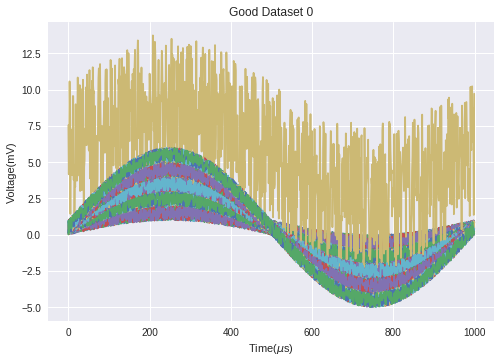

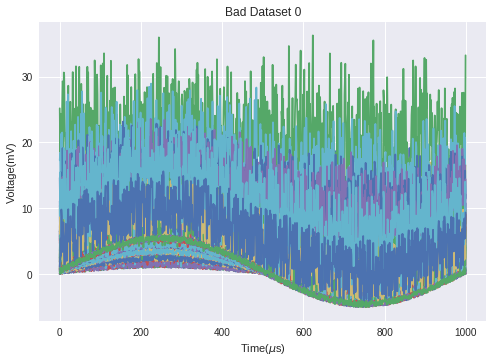

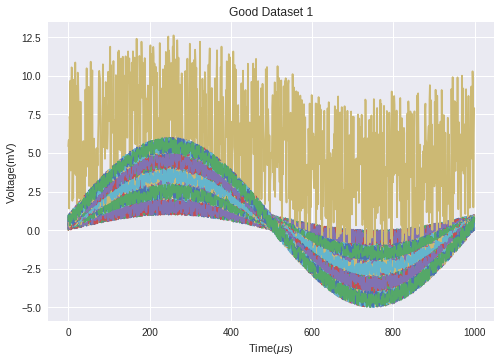

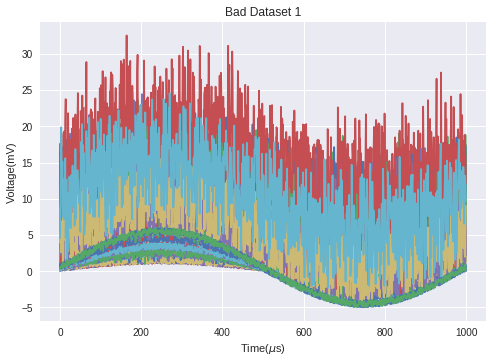

In [48]:
# plot a couple sample sets
for i in range(2):
    plot_sim(g_data[i], g_elec[i], i, False)
    plot_sim(b_data[i], b_elec[i], i, True)

Kurtosis Good
Test
[]
Here
Bad Chans: [28]


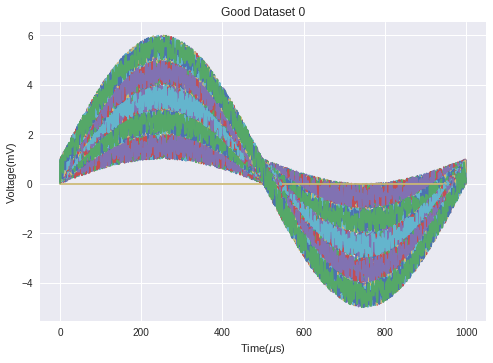

Test
[]
Here
Bad Chans: [10]


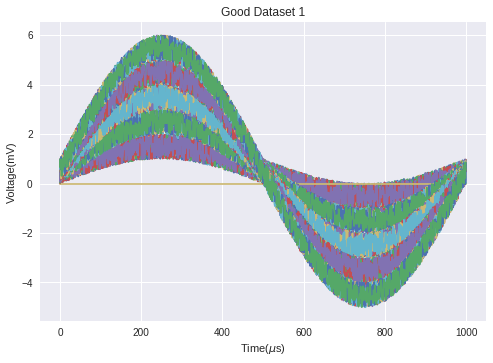

Test
[]
Here
Bad Chans: [25]


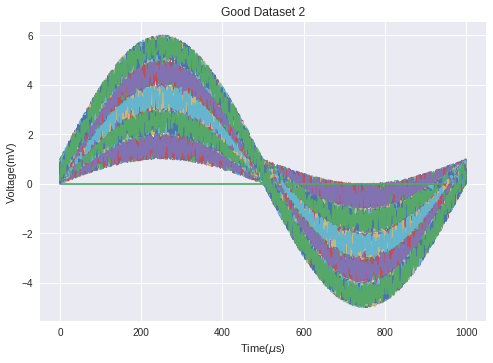

Test
[]
Here
Bad Chans: [19]


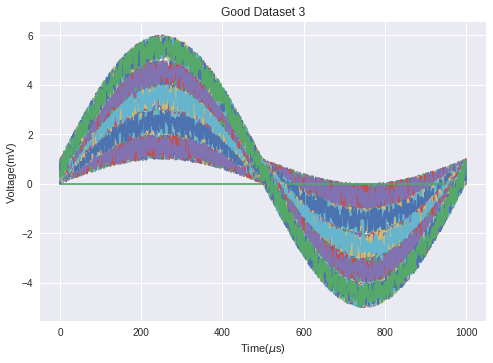

Test
[]
Here
Bad Chans: [29]


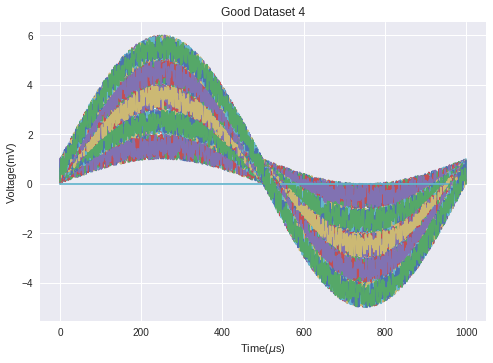

Test
[]
Here
Bad Chans: [42]


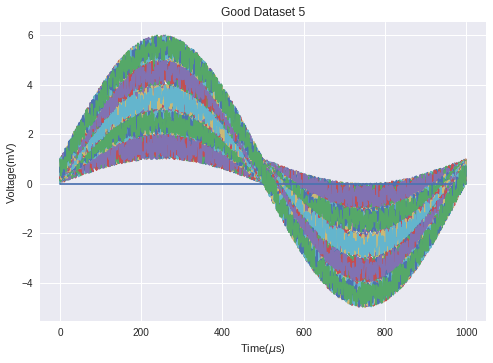

Test
[]
Here
Bad Chans: []


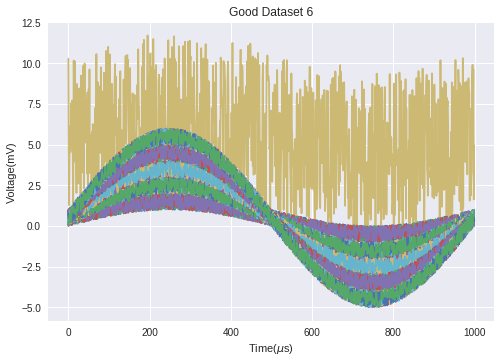

Test
[]
Here
Bad Chans: []


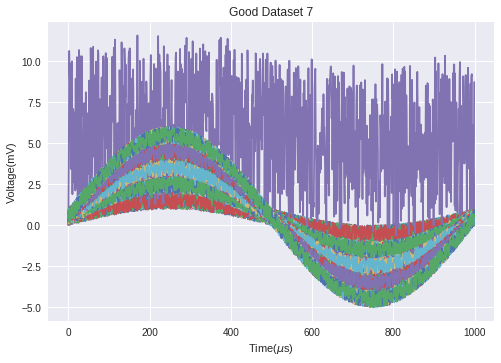

Test
[]
Here
Bad Chans: [21]


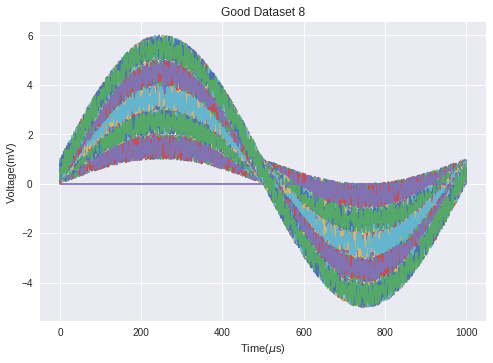

Test
[]
Here
Bad Chans: []


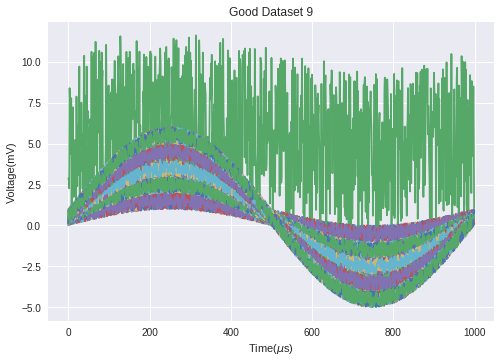

In [49]:
import sys
sys.path.append('..')
from panda.methods.bad_chans import bad_detec
from panda import config
p_global = config.params['p_global']
# Now run the algos

print "Kurtosis Good"
# Just Kurtosis
k_g_out = []
for i in range(len(g_data)):
    p_local = {}
    p_global['bad_detec']['verbose'] = False
    p_global['bad_detec']['measure'] = ['kurtosis']
    (tmp, p_local) = bad_detec(g_data[i], {}, p_global)
    k_g_out.append(tmp)
    print "Bad Chans:", p_local['bad_chans']
    plot_sim(k_g_out[i], g_elec[i], i)


KS Good
Test
[]
Here
Bad Chans: [28]


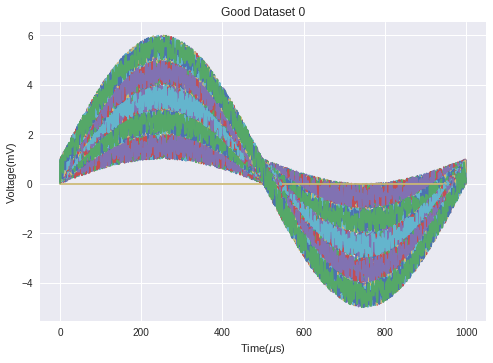

Test
[]
Here
Bad Chans: [10]


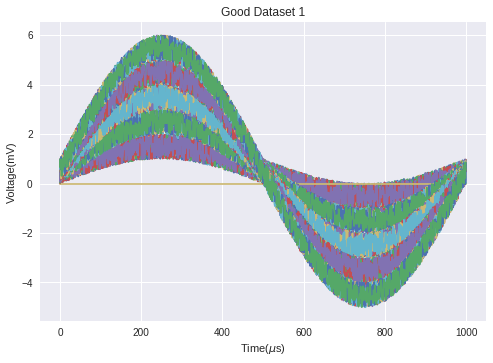

Test
[]
Here
Bad Chans: [25]


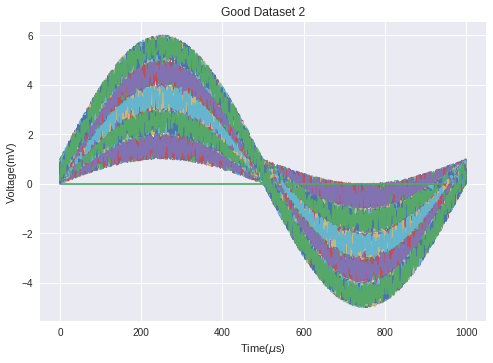

Test
[]
Here
Bad Chans: [19]


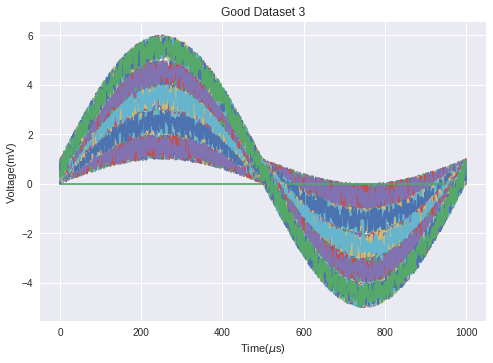

Test
[]
Here
Bad Chans: [29]


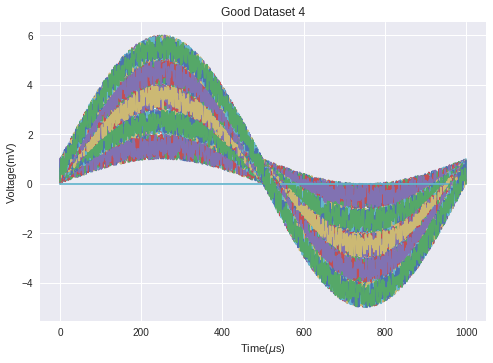

Test
[]
Here
Bad Chans: [42]


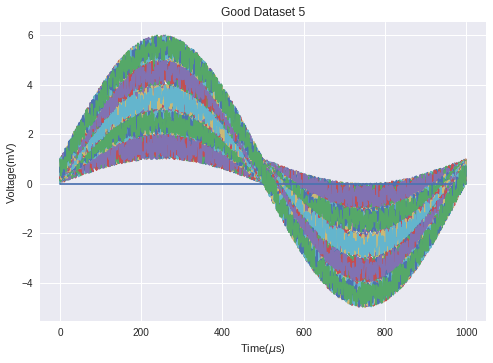

Test
[]
Here
Bad Chans: []


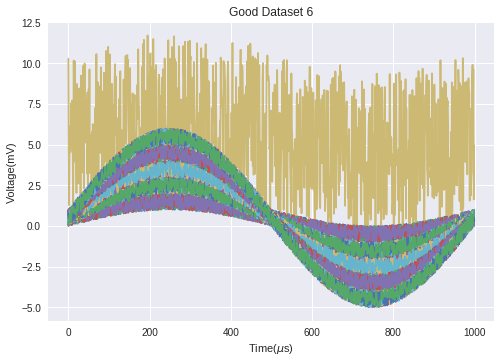

Test
[]
Here
Bad Chans: []


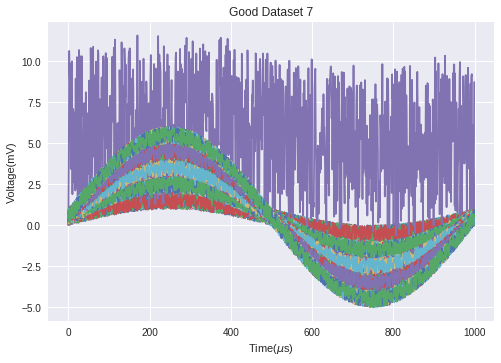

Test
[]
Here
Bad Chans: [21]


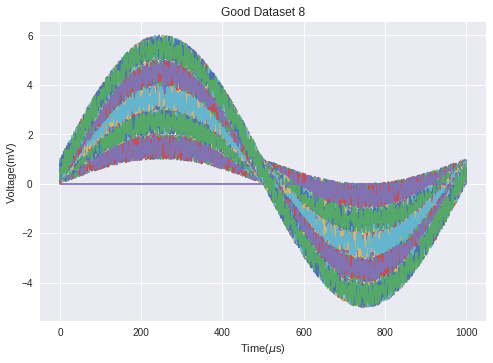

Test
[]
Here
Bad Chans: []


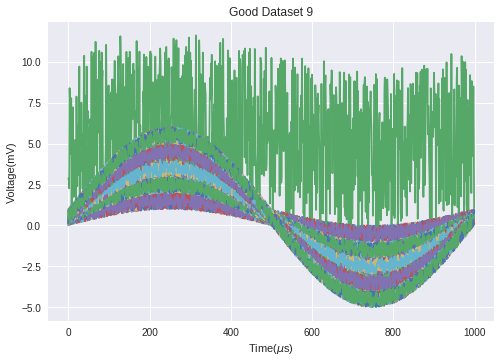

In [54]:
print "KS Good"
# Just KS
ks_g_out = []
for i in range(len(g_data)):
    p_local = {}
    p_global['bad_detec']['verbose'] = False
    p_global['bad_detec']['measure'] = ['prob']
    (tmp, p_local) = bad_detec(g_data[i], {}, p_global)
    ks_g_out.append(tmp)
    print "Bad Chans:", p_local['bad_chans']
    plot_sim(ks_g_out[i], [], i)


Kurtosis Bad
Test
[]
Here
Bad Chans: []


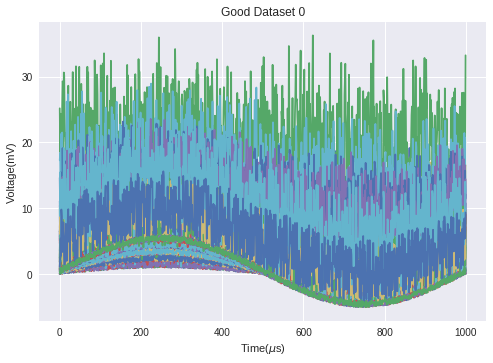

Test
[]
Here
Bad Chans: []


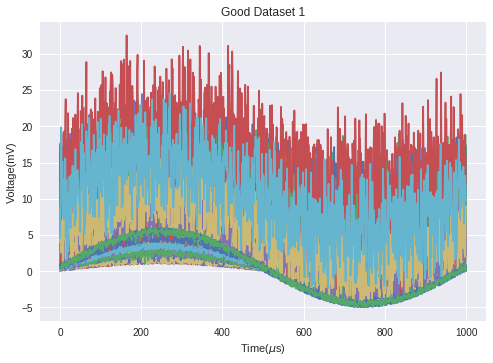

Test
[]
Here
Bad Chans: []


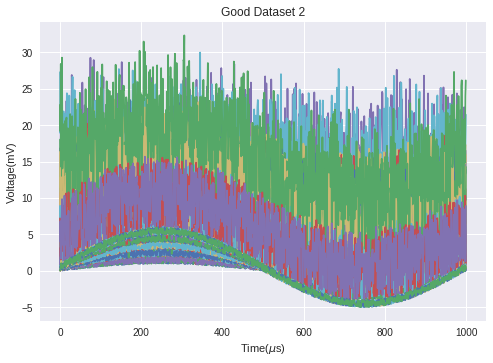

Test
[]
Here
Bad Chans: []


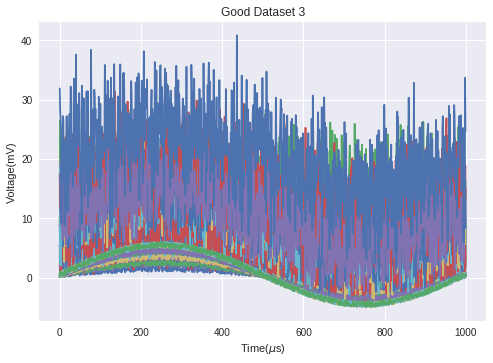

Test
[]
Here
Bad Chans: []


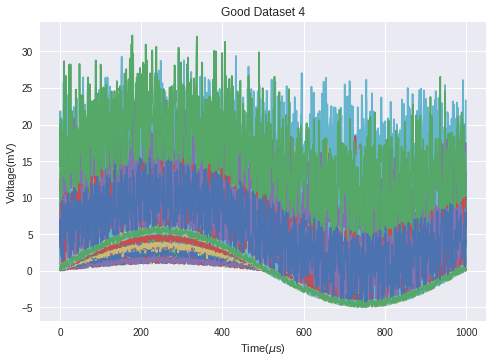

Test
[]
Here
Bad Chans: []


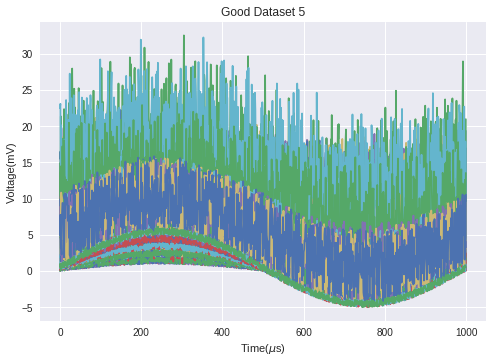

Test
[]
Here
Bad Chans: []


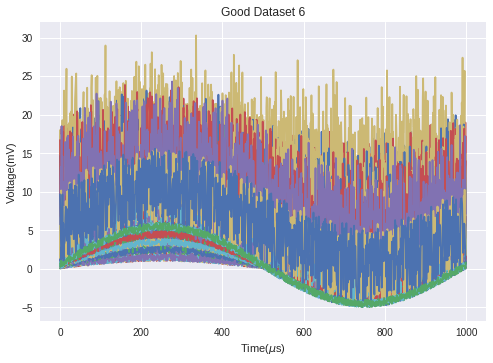

Test
[]
Here
Bad Chans: []


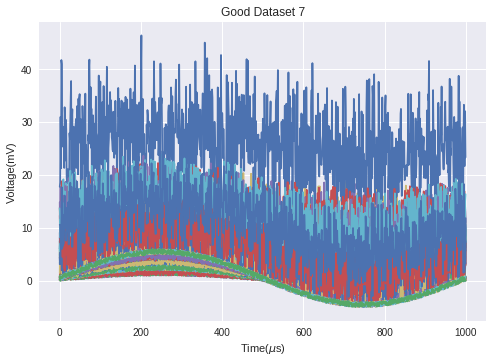

Test
[]
Here
Bad Chans: []


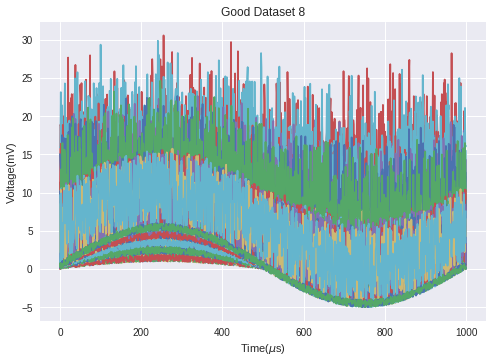

Test
[]
Here
Bad Chans: []


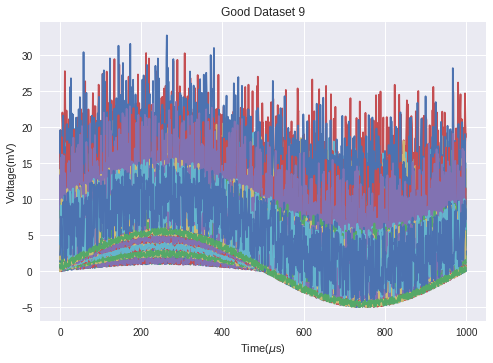

In [51]:
print "Kurtosis Bad"
# Just Kurtosis
k_b_out = []
for i in range(len(b_data)):
    p_local = {}
    p_global['bad_detec']['verbose'] = False
    p_global['bad_detec']['measure'] = ['kurtosis']
    (tmp, p_local) = bad_detec(b_data[i], {}, p_global)
    k_b_out.append(tmp)
    print "Bad Chans:", p_local['bad_chans']
    plot_sim(k_b_out[i], b_elec[i], i)


KS Bad
Test
[]
Here
Bad Chans: []


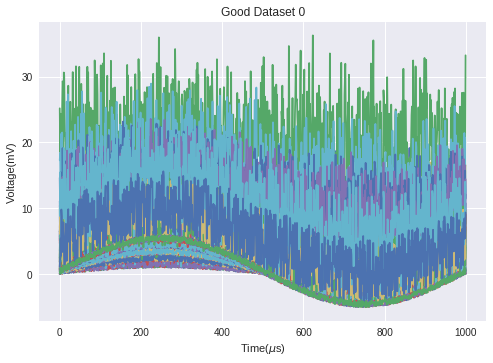

Test
[]
Here
Bad Chans: []


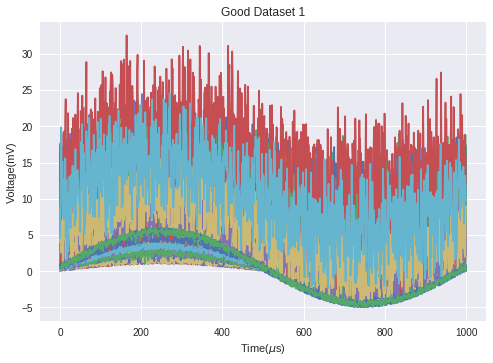

Test
[]
Here
Bad Chans: []


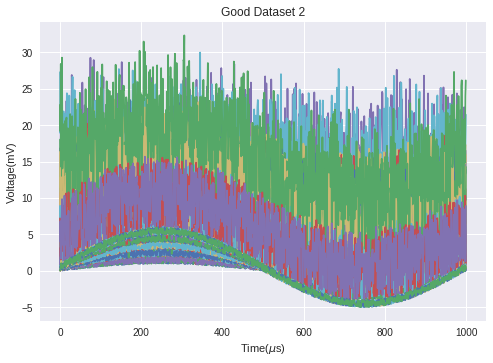

Test
[]
Here
Bad Chans: []


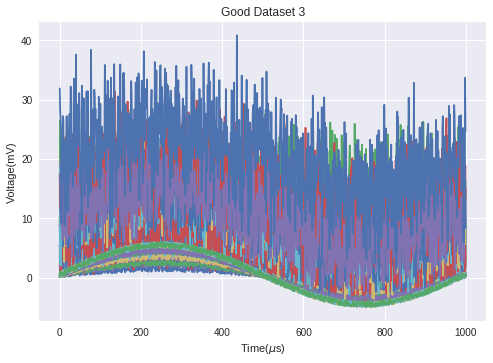

Test
[]
Here
Bad Chans: []


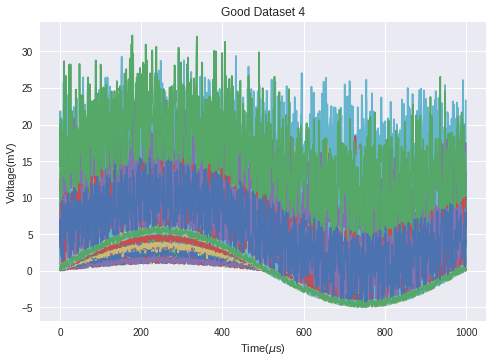

Test
[]
Here
Bad Chans: []


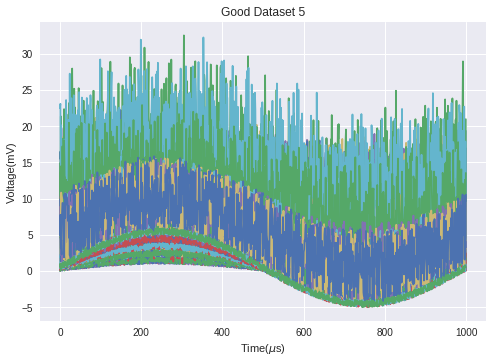

Test
[]
Here
Bad Chans: []


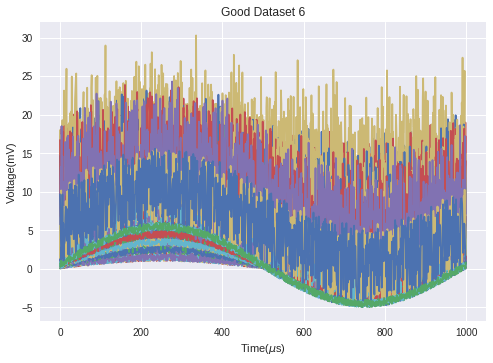

Test
[]
Here
Bad Chans: []


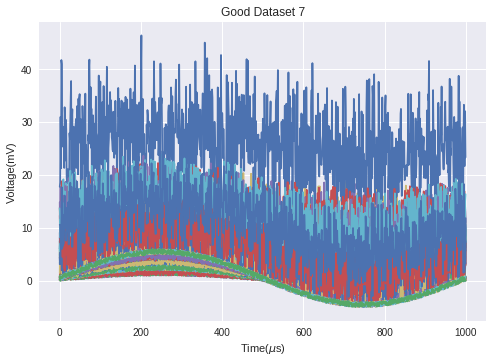

Test
[]
Here
Bad Chans: []


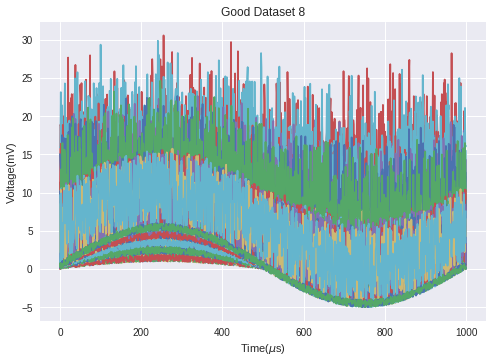

Test
[]
Here
Bad Chans: []


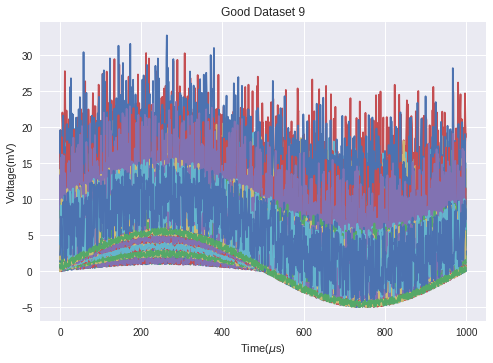

In [53]:
￼print "KS Bad"
# Just KS
ks_b_out = []
for i in range(len(g_data)):
    p_local = {}
    p_global['bad_detec']['verbose'] = False
    p_global['bad_detec']['measure'] = ['prob']
    (tmp, p_local) = bad_detec(b_data[i], {}, p_global)
    ks_b_out.append(tmp)
    print "Bad Chans:", p_local['bad_chans']
    plot_sim(ks_b_out[i], [], i)


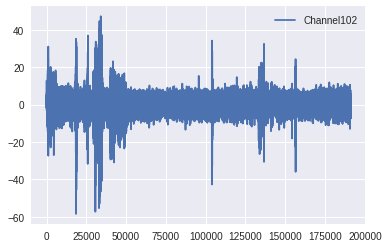

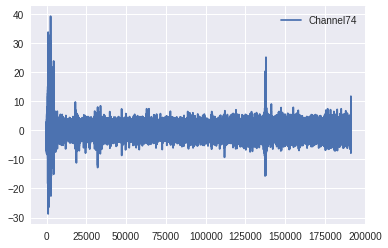

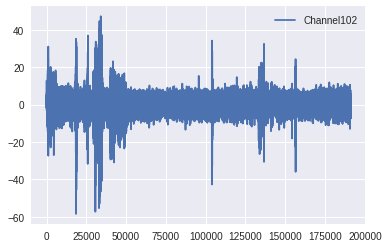

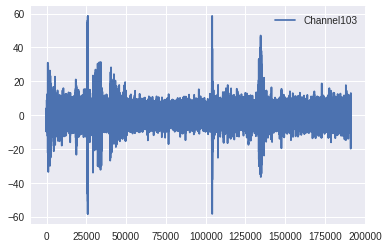

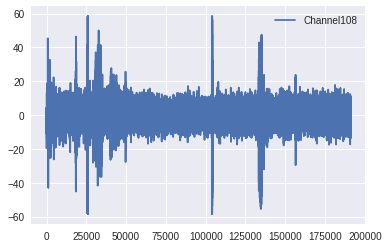

In [69]:
for i in p_local['bad_chans']:
    plt.plot(D[i, :], label = 'Channel' + str(i))
    plt.legend()
    plt.show()

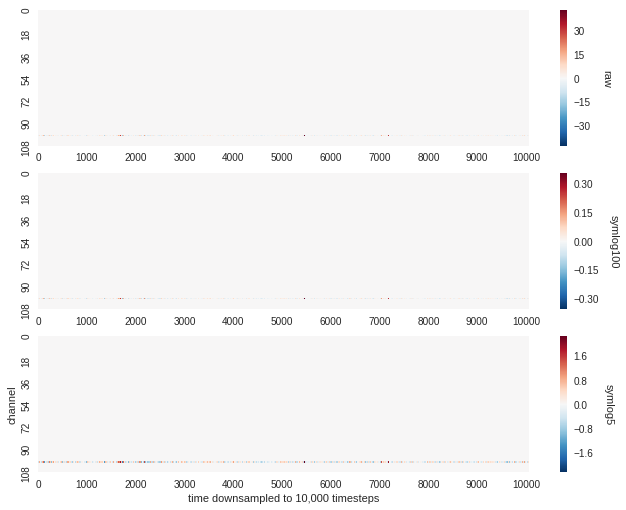

In [62]:
viz.heatmap((D_bd - D), p_local, p_global)

#### Interpolation...
Now we interpolate the channels which were detected as bad with a wavelet based interpolation technique.

In [63]:
from panda.methods.interpolation import wave_interp
(D_int, p_local) = wave_interp(D_bd, p_local, p_global)

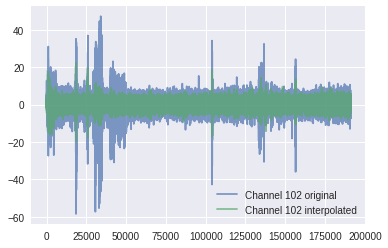

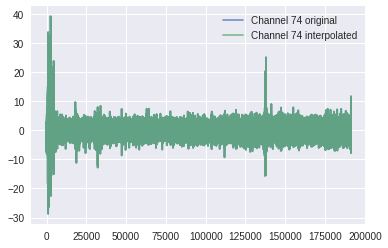

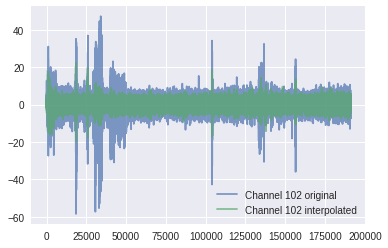

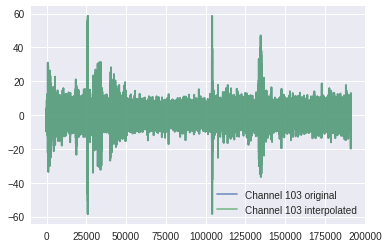

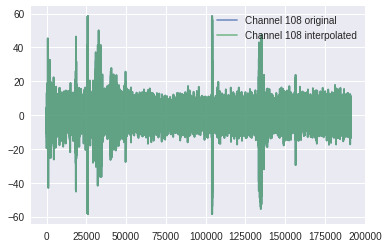

In [70]:
for i in p_local['bad_chans']:
    plt.plot(D[i, :],
             label = 'Channel ' + str(i) + ' original',
             alpha = 0.7)
    plt.plot(D_int[i, :],
             label = 'Channel ' + str(i) + ' interpolated',
             alpha = .7)
    plt.legend()
    plt.show()

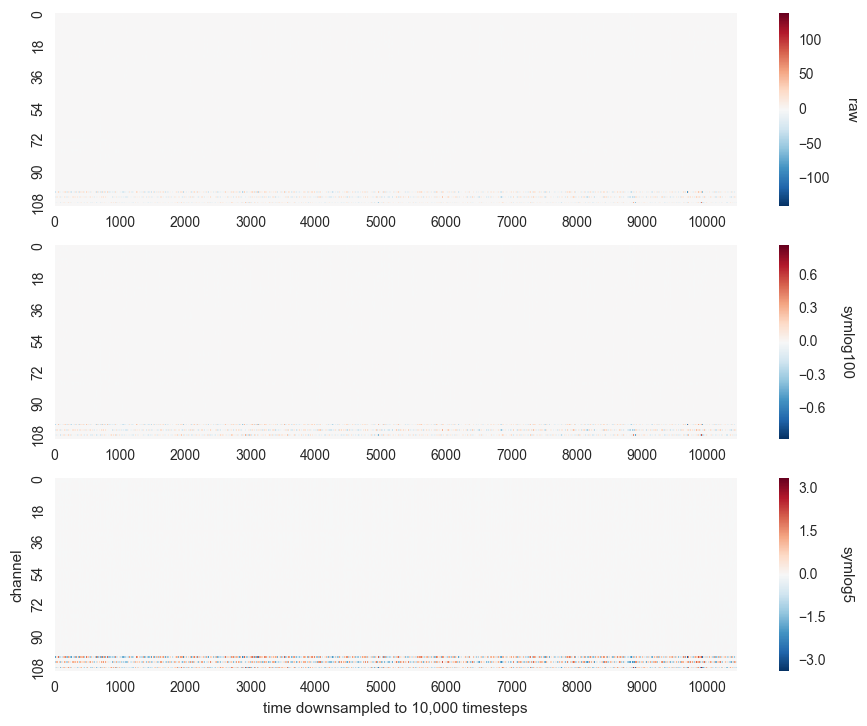

In [13]:
viz.heatmap((D_int - D), p_local, p_global)

#### Results... (just deleting)
Here are the discriminibility results after running this function on an entire dataset (after the preceding functions in the pipeline)...
![image](../results/bids_raw/disc-heat-_bad_detec.png)

#### Results... (deleting and interpolating)
Here are the discriminibility results after running this function on an entire dataset (after the preceding functions in the pipeline)...
![image](../results/bids_raw/disc-heat-_wave_interp.png)

In [67]:
p_global['bad_detec']['measure'] = ['prob', 'kurtosis']